# Data Science for Energy Systems/ Assignment 3 – LNG Terminals & Electricity Markets

Due date of the assignment: 06/february/2023
<br>Group: C
<br>Students: 
- Aziz El Medini  
- Sajid Kabeer
- Fernanda Zambrano Ceballos
- Matthias Zander


## Introduction and general information
Description of the assignment and the following code

Country selected: Tunisia
Complementary info




### Imports

The packages used in the assignment are imported in the following line code:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import rasterio as rio
from rasterio.plot import show
import xarray as xr
import os
import country_converter as coco
import cdsapi
from shapely.geometry import Point
import pypsa
import cartopy
import cartopy.crs as ccrs

### Dataframes, includers and excluders

The core datasets needed to complete this group assignment are provided here:
https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq


## Shapes: import of the country's shape and selection of the regions

Take the GADM dataset to split the country of your choice into at least 5 regions on which all further
modelling will built. If there are more GADM regions, you may aggregate the regions down to that number.
For each region determine a representative point (e.g. centroid). If your country is not landlocked, also
extract the shape of the Exclusive Economic Zone.

### Country's shape

In [2]:
gadm_tunisia = gpd.read_file("gadm_410-levels-ADM_1-TUN.gpkg")

In [3]:
#gadm_tunisia

<AxesSubplot:>

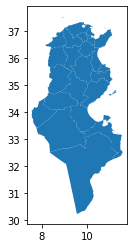

In [4]:
gadm_tunisia.plot()

<AxesSubplot:>

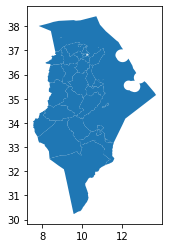

In [5]:
eez = gpd.read_file("eez_v11.gpkg")
eez_tunisia=eez.loc[eez.TERRITORY1=="Tunisia"]
tunisia=pd.concat([gadm_tunisia, eez_tunisia])
tunisia.plot()

points = tunisia.representative_point()

fig1, ax = plt.subplots(figsize=(15,7))
gadm_tunisia.plot(ax=ax, color="khaki")
eez_tunisia.plot(ax=ax, color="paleturquoise")
points.plot(ax=ax, color='red', markersize=3);

Select the regions for the study

<AxesSubplot:>

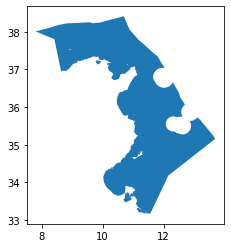

In [6]:
eez_tunisia.plot()

In [7]:
regions_tun= ['North East','North West','North East','North East','South East','South West','North West',
          'Centre West','Centre West','South West','North West','Centre East','North East','South East',
         'Centre East','North East','Centre East','Centre West','North West','Centre East','South East',
          'South West','North East','North East','Marine Region']
          
tunisia.insert(loc=len(tunisia.columns), column='regions_tun', value=regions_tun)

In [8]:
regions = tunisia.dissolve(by='regions_tun')
regions.reset_index(inplace=True)
regions["centroid"]= regions.geometry.centroid
#regions["colors"] = ["lightcoral", "violet","paleturquoise","wheat","lightgreen","peru","wheat""]
regions["colors"] = ["wheat", "wheat","paleturquoise","wheat","wheat","wheat","wheat"]
regions

C:\Users\bilwi\AppData\Local\Temp/ipykernel_14860/2476725320.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions["centroid"]= regions.geometry.centroid


,regions_tun,geometry,GID_0,GID_1,COUNTRY,NAME_1,MRGID,GEONAME,MRGID_TER1,POL_TYPE,...,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,centroid,colors
0,Centre East,"MULTIPOLYGON (((11.45292 34.69708, 11.45486 34...",TUN,TUN.12_1,Tunisia,Mahdia,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.46398 35.17463),wheat
1,Centre West,"POLYGON ((9.64888 34.31921, 9.63264 34.31587, ...",TUN,TUN.8_1,Tunisia,Kairouan,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.34577 35.23423),wheat
2,Marine Region,"POLYGON ((13.61000 35.25000, 13.68389 35.15361...",None,None,None,None,8366.0,Tunisian Exclusive Economic Zone,2214.0,200NM,...,None,None,788.0,NaN,NaN,788.0,NaN,NaN,POINT (11.05319 36.00133),paleturquoise
3,North East,"MULTIPOLYGON (((10.50458 36.73125, 10.50319 36...",TUN,TUN.1_1,Tunisia,Ariana,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.06541 36.74580),wheat
4,North West,"POLYGON ((9.28485 35.68320, 9.29958 35.67127, ...",TUN,TUN.2_1,Tunisia,Béja,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.00839 36.30544),wheat
5,South East,"MULTIPOLYGON (((11.45319 33.17347, 11.45347 33...",TUN,TUN.5_1,Tunisia,Gabès,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.07584 32.42933),wheat
6,South West,"POLYGON ((9.55500 33.60525, 9.56998 33.59874, ...",TUN,TUN.6_1,Tunisia,Gafsa,NaN,None,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,POINT (8.70984 33.64366),wheat


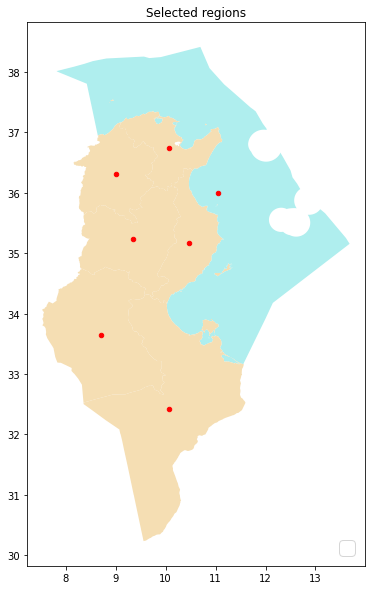

In [9]:
fig2, ax = plt.subplots(figsize=(20,10))
regions.plot(ax=ax, color=regions.colors)
plt.legend(labels=regions.index, ncol=3, loc="lower right", shadow= False, fontsize=20)
plt.scatter(regions['centroid'].x, regions['centroid'].y, marker='o', color='red', s=20 )
plt.title("Selected regions")
plt.show()

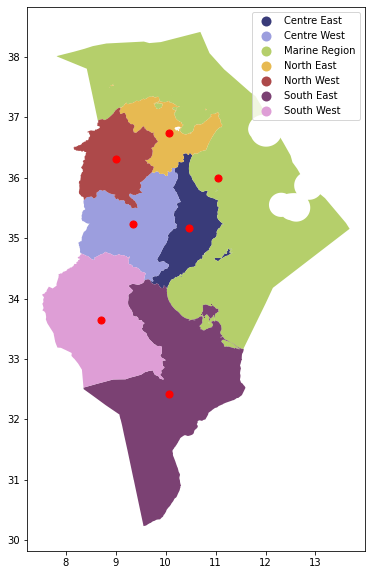

In [10]:
regions.plot(column='regions_tun', cmap='tab20b', legend=True,figsize=(20,10))
plt.scatter(regions['centroid'].x, regions['centroid'].y, marker='o', color='red', s=50)
plt.show()


## Renewable potentials: Land eligibility, availability matrix and capacity factors
Renewable potentials are computed for solar PV, onshore wind and, where applicable, offshore wind. The preparation consists of two main components

In [11]:
#regions.set_index('regions_tun',inplace=True)

In [12]:
regions.drop(2,inplace = True)

In [13]:
regions= regions[['geometry','centroid','colors','regions_tun']]

In [14]:
regions

,geometry,centroid,colors,regions_tun
0,"MULTIPOLYGON (((11.45292 34.69708, 11.45486 34...",POINT (10.46398 35.17463),wheat,Centre East
1,"POLYGON ((9.64888 34.31921, 9.63264 34.31587, ...",POINT (9.34577 35.23423),wheat,Centre West
3,"MULTIPOLYGON (((10.50458 36.73125, 10.50319 36...",POINT (10.06541 36.74580),wheat,North East
4,"POLYGON ((9.28485 35.68320, 9.29958 35.67127, ...",POINT (9.00839 36.30544),wheat,North West
5,"MULTIPOLYGON (((11.45319 33.17347, 11.45347 33...",POINT (10.07584 32.42933),wheat,South East
6,"POLYGON ((9.55500 33.60525, 9.56998 33.59874, ...",POINT (8.70984 33.64366),wheat,South West


### Extracting Regional shapes

In [15]:
shape = regions.to_crs(3035).geometry #The shape of tunisia

In [16]:
#shape of regions
shape_ce = regions[regions['regions_tun'] == 'Centre East'].to_crs(3035).geometry
shape_cw = regions[regions['regions_tun'] == 'Centre West'].to_crs(3035).geometry
shape_ne = regions[regions['regions_tun'] == 'North East'].to_crs(3035).geometry
shape_nw = regions[regions['regions_tun'] == 'North West'].to_crs(3035).geometry
shape_se = regions[regions['regions_tun'] == 'South East'].to_crs(3035).geometry
shape_sw = regions[regions['regions_tun'] == 'South West'].to_crs(3035).geometry

In [17]:
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = show(masked, transform=transform, cmap='Oranges', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=2)
    
def area(masked, excluder, shape):
    percent=(np.int64(masked.sum()) * np.int64(excluder.res**2)  * 100 / (shape.geometry.area.sum()))
    print("The percentage of available area for technology deployment is: " +str(percent)+" %")
    return 

### Onshore Wind Potential

##### EXcluder stays the same for the land eligibility for onshore wind

In [18]:
excluder_onshore = ExclusionContainer(crs=3035, res=300)

#Airports
excluder_onshore.add_geometry("ne_10m_airports.gpkg", buffer=10000)
#Major roads
excluder_onshore.add_geometry("ne_10m_roads.gpkg", buffer=300)
#Natural protection area
fn1 = 'WDPA_Oct2022_Public_shp-TUN.tif'
excluder_onshore.add_raster(fn1, crs=3035)
#Elevation
fn2 = 'GEBCO_2014_2D-TN.nc'
excluder_onshore.add_raster(fn2, codes=lambda x: x>2000, crs=4326)
#Suitable land cover classes with 1km distance to built-up areas
fn3 = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-TN.tif'
excluder_onshore.add_raster(fn3, codes=[50], buffer=1000, crs=4326)
excluder_onshore.add_raster(fn3, codes=[20,30,40,60], crs=4326, invert=True)

masked_ce, transform_ce = shape_availability(shape_ce, excluder_onshore)
plot_area(masked_ce,transform_ce,shape_ce)
area(masked_ce,excluder_onshore,shape_ce)


masked_cw, transform_cw = shape_availability(shape_cw, excluder_onshore)
#plot_area(masked_cw,transform_cw,shape_cw)
area(masked_cw,excluder_onshore,shape_cw)


masked_ne, transform_ne = shape_availability(shape_ne, excluder_onshore)
#plot_area(masked_ne,transform_ne,shape_ne)
area(masked_ne,excluder_onshore,shape_ne)


masked_nw, transform_nw = shape_availability(shape_nw, excluder_onshore)
#plot_area(masked_nw,transform_nw,shape_nw)
area(masked_nw,excluder_onshore,shape_nw)


masked_se, transform_se = shape_availability(shape_se, excluder_onshore)
#plot_area(masked_se,transform_se,shape_se)
area(masked_se,excluder_onshore,shape_se)

masked_sw, transform_sw = shape_availability(shape_sw, excluder_onshore)
#plot_area(masked_sw,transform_sw,shape_sw)
area(masked_sw,excluder_onshore,shape_sw)

C:\Users\bilwi\anaconda3\lib\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


TypeError: 'DataArray' object is not callable

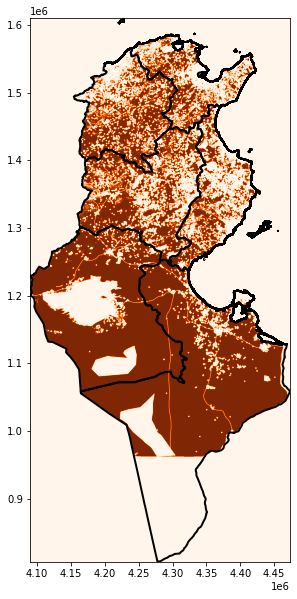

In [181]:
masked_onshore, transform_onshore = shape_availability(shape, excluder_onshore)
plot_area(masked_onshore,transform_onshore,shape)
area(masked_onshore,excluder_onshore,shape)

## Solar

In [20]:
excluder_solar = ExclusionContainer(crs=3035, res=300)

#Natural protection area
fn = 'WDPA_Oct2022_Public_shp-TUN.tif'
excluder_solar.add_raster(fn, crs=3035)

#Suitable land cover classes with 1km distance to built-up areas
fn = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-TN.tif'
excluder_solar.add_raster(fn, codes=[20,30,40,60], crs=4326, invert=True)

masked_ce, transform_ce = shape_availability(shape_ce, excluder_solar)
#plot_area(masked_ce,transform_ce,shape_ce)
area(masked_ce,excluder_solar,shape_ce)

masked_cw, transform_cw = shape_availability(shape_cw, excluder_solar)
#plot_area(masked_cw,transform_cw,shape_cw)
area(masked_cw,excluder_solar,shape_cw)

masked_ne, transform_ne = shape_availability(shape_ne, excluder_solar)
#plot_area(masked_ne,transform_ne,shape_ne)
area(masked_ne,excluder_solar,shape_ne)

masked_nw, transform_nw = shape_availability(shape_nw, excluder_solar)
#plot_area(masked_nw,transform_nw,shape_nw)
area(masked_nw,excluder_solar,shape_nw)

masked_se, transform_se = shape_availability(shape_se, excluder_solar)
#plot_area(masked_se,transform_se,shape_se)
area(masked_se,excluder_solar,shape_se)

masked_sw, transform_sw = shape_availability(shape_sw, excluder_solar)
#plot_area(masked_sw,transform_sw,shape_sw)
area(masked_sw,excluder_solar,shape_sw)

C:\Users\bilwi\anaconda3\lib\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


The percentage of available area for technology deployment is: 76.62876988743645 %


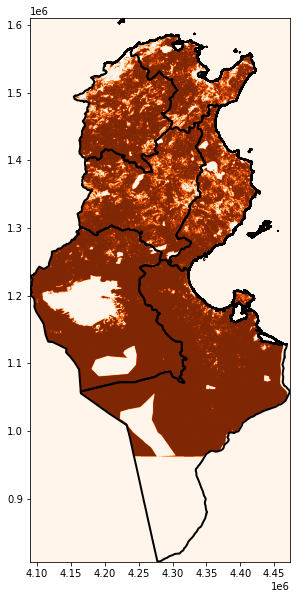

In [21]:
masked_solar, transform_solar = shape_availability(shape, excluder_solar)
plot_area(masked_solar,transform_solar,shape)
area(masked_solar,excluder_solar,shape)

### offshore

In [22]:
regions

,geometry,centroid,colors,regions_tun
0,"MULTIPOLYGON (((11.45292 34.69708, 11.45486 34...",POINT (10.46398 35.17463),wheat,Centre East
1,"POLYGON ((9.64888 34.31921, 9.63264 34.31587, ...",POINT (9.34577 35.23423),wheat,Centre West
3,"MULTIPOLYGON (((10.50458 36.73125, 10.50319 36...",POINT (10.06541 36.74580),wheat,North East
4,"POLYGON ((9.28485 35.68320, 9.29958 35.67127, ...",POINT (9.00839 36.30544),wheat,North West
5,"MULTIPOLYGON (((11.45319 33.17347, 11.45347 33...",POINT (10.07584 32.42933),wheat,South East
6,"POLYGON ((9.55500 33.60525, 9.56998 33.59874, ...",POINT (8.70984 33.64366),wheat,South West


In [23]:
excluder_offshore = ExclusionContainer(crs=3035, res=300)

#Natural protection area
excluder_offshore.add_raster('WDPA_Oct2022_Public_shp-TUN.tif', crs=3035)

#Elevation
excluder_offshore.add_raster('GEBCO_2014_2D-TN.nc', codes=lambda x: x<-50, crs=4326)


#Economical Zone-10km distance to shore
excluder_offshore.add_geometry(shape,buffer=10000)

C:\Users\bilwi\anaconda3\lib\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


The percentage of available area for technology deployment is: 15.992150845198065 %


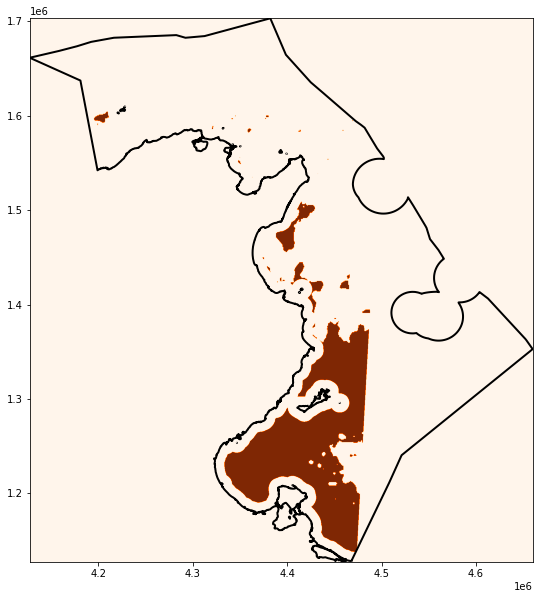

In [24]:
shape_offshore = eez_tunisia.to_crs(3035).geometry
masked_offshore, transform_offshore = shape_availability(shape_offshore, excluder_offshore)
plot_area(masked_offshore,transform_offshore,shape_offshore)
area(masked_offshore,excluder_offshore,shape_offshore)

### Historical weather data from ERA5

A cutout for onshore wind and solar is created for the year 2020.

### Onshore and Solar

In [25]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

cutout_land = atlite.Cutout(
   path="weather_2020",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2020",
)


C:\Users\bilwi\anaconda3\lib\site-packages\atlite\cutout.py:187: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [26]:
cutout_land.prepare()

<Cutout "weather_2020">
 x = 7.50 ⟷ 11.75, dx = 0.25
 y = 30.00 ⟷ 37.75, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [27]:
cutout_land.data

<xarray.Dataset>
Dimensions:           (x: 18, y: 32, time: 8784)
Coordinates:
  * x                 (x) float64 7.5 7.75 8.0 8.25 ... 11.0 11.25 11.5 11.75
  * y                 (y) float64 30.0 30.25 30.5 30.75 ... 37.25 37.5 37.75
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(32,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(32, 18), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 32, 18), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['wind', 'height', 'influx', 'runoff', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-01-31 00:27:59 GMT by grib_to_netcdf-2.25.1: /op...

In [28]:
A_onshore = cutout_land.availabilitymatrix(regions, excluder_onshore)

Compute availability matrix: 100%|███████████████████████████████████████████████| 6/6 [02:00<00:00, 20.08s/ gridcells]


In [29]:
A_solar = cutout_land.availabilitymatrix(regions, excluder_solar)

Compute availability matrix: 100%|███████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/ gridcells]


Availibility matrix

## Cutout for the eez zone

In [30]:
minx, miny, maxx, maxy = eez_tunisia.total_bounds
buffer = 0.25

cutout_ocean = atlite.Cutout(
   path="tunisia_eez.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2020",
)

C:\Users\bilwi\anaconda3\lib\site-packages\atlite\cutout.py:187: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [31]:
cutout_ocean.prepare()

<Cutout "tunisia_eez">
 x = 7.75 ⟷ 13.75, dx = 0.25
 y = 33.00 ⟷ 38.50, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [32]:
A_offshore = cutout_ocean.availabilitymatrix(shape_offshore, excluder_offshore)

Compute availability matrix: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/ gridcells]


### Capacity factors for solar and offshore and onshore wind
Wind and solar capacity factor time series, per modeled region, are calculated using the availability matrix and the corresponding atlite conversion functions, calculated before.

- For onshore wind, use a "Vestas_V112_3MW" as a reference turbine.
- For offshore wind, use an "NREL_ReferenceTurbine_5MW_offshore" as a reference turbine.
- For solar, use a "CdTe" solar panel with optimal latitude orientation.
- For both wind and solar, assume a deployment density of 3 MW/km2.

#### On-shore wind profiles

In [33]:
cap_per_sqkm = 5
area = cutout_land.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
capacity_matrix_on_shore = A_onshore.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [34]:
regions=regions.set_index('regions_tun')

In [35]:
on_shore = cutout_land.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix_on_shore,
    index=regions.index,
    per_unit=True,
)

In [36]:
on_shore = pd.DataFrame(on_shore.to_pandas())
on_shore= on_shore.resample('3H').mean()

In [37]:
on_shore.head()

regions_tun,Centre East,Centre West,North East,North West,South East,South West
time,,,,,,
2020-01-01 00:00:00,0.551149,0.224086,0.106193,0.025033,0.801307,0.308578
2020-01-01 03:00:00,0.523027,0.181549,0.140303,0.041358,0.625376,0.233771
2020-01-01 06:00:00,0.466025,0.135119,0.119091,0.042478,0.533526,0.174498
2020-01-01 09:00:00,0.220945,0.082466,0.137027,0.064997,0.378418,0.056828
2020-01-01 12:00:00,0.282767,0.119331,0.328306,0.189411,0.286584,0.026476


In [38]:
on_shore.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2020-01-01 00:00:00 to 2020-12-31 21:00:00
Freq: 3H
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Centre East  2928 non-null   float64
 1   Centre West  2928 non-null   float64
 2   North East   2928 non-null   float64
 3   North West   2928 non-null   float64
 4   South East   2928 non-null   float64
 5   South West   2928 non-null   float64
dtypes: float64(6)
memory usage: 160.1 KB


fig1, ax1 = plt.subplots(figsize = (20,6))
ax1.plot(on_shore['Centre East'],color = 'green')
ax1.set_xlabel('Time',fontsize=(18))
ax1.set_ylabel('pu',fontsize=(18))
ax1.set_title('On wind capacity factor for the month of july for Centre East',fontsize=(20))

xlim=(pd.Timestamp('2015-07-01 00:00:00'), pd.Timestamp('2015-07-31 23:00:00'))


<AxesSubplot:xlabel='time'>

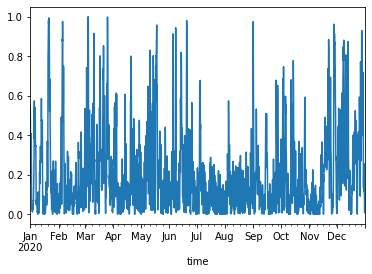

In [39]:
on_shore.iloc[:,0].plot()

#### solar pv profiles

In [40]:
cap_per_sqkm = 5
area = cutout_land.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
capacity_matrix_solar = A_solar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [41]:
solar = cutout_land.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=regions.index,
    per_unit=True,
)

[########################################] | 100% Completed |  4.1s


In [42]:
solar = pd.DataFrame(solar.to_pandas())
solar= solar.resample('3H').mean()

In [43]:
solar.head()

regions_tun,Centre East,Centre West,North East,North West,South East,South West
time,,,,,,
2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 06:00:00,0.064983,0.060504,0.043679,0.040643,0.075737,0.078947
2020-01-01 09:00:00,0.464863,0.470388,0.338864,0.369806,0.521389,0.594267
2020-01-01 12:00:00,0.425983,0.356145,0.362368,0.282259,0.592407,0.665322


fig1, ax1 = plt.subplots(figsize = (20,6))
ax1.plot(solar['Centre East'],color = 'green')
ax1.set_xlabel('Time',fontsize=(18))
ax1.set_ylabel('pu',fontsize=(18))
ax1.set_title('Solar capacity factor for the month of july for Centre East',fontsize=(20))

xlim=(pd.Timestamp('2015-07-01 00:00:00'), pd.Timestamp('2015-07-31 23:00:00'))

<AxesSubplot:xlabel='time'>

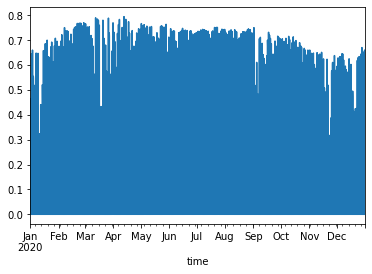

In [44]:
solar.iloc[:,0].plot()

#### offshore wind profiles

In [45]:
cap_per_sqkm = 5
area = cutout_ocean.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
capacity_matrix_off_shore = A_offshore.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [46]:
eez_tunisia=eez_tunisia.set_index('GEONAME')

In [47]:
off_shore = cutout_ocean.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=capacity_matrix_off_shore,
    index=eez_tunisia.index,
    per_unit=True,
)

In [48]:
off_shore = pd.DataFrame(off_shore.to_pandas())
off_shore= off_shore.resample('3H').mean()

In [49]:
off_shore.head()

GEONAME,Tunisian Exclusive Economic Zone
time,
2020-01-01 00:00:00,0.850863
2020-01-01 03:00:00,0.740326
2020-01-01 06:00:00,0.694118
2020-01-01 09:00:00,0.640852
2020-01-01 12:00:00,0.508327


fig1, ax1 = plt.subplots(figsize = (20,6))
ax1.plot(solar['Centre East'],color = 'green')
ax1.set_xlabel('Time',fontsize=(18))
ax1.set_ylabel('pu',fontsize=(18))
ax1.set_title('O capacity factor for the month of july for Centre East',fontsize=(20))

xlim=(pd.Timestamp('2015-07-01 00:00:00'), pd.Timestamp('2015-07-31 23:00:00'))

<AxesSubplot:xlabel='time'>

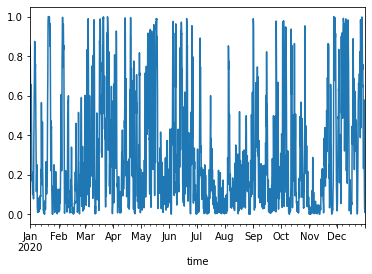

In [50]:
off_shore.iloc[:,0].plot()

## Model

In [51]:
n = pypsa.Network()

In [52]:
regions

,geometry,centroid,colors
regions_tun,,,
Centre East,"MULTIPOLYGON (((11.45292 34.69708, 11.45486 34...",POINT (10.46398 35.17463),wheat
Centre West,"POLYGON ((9.64888 34.31921, 9.63264 34.31587, ...",POINT (9.34577 35.23423),wheat
North East,"MULTIPOLYGON (((10.50458 36.73125, 10.50319 36...",POINT (10.06541 36.74580),wheat
North West,"POLYGON ((9.28485 35.68320, 9.29958 35.67127, ...",POINT (9.00839 36.30544),wheat
South East,"MULTIPOLYGON (((11.45319 33.17347, 11.45347 33...",POINT (10.07584 32.42933),wheat
South West,"POLYGON ((9.55500 33.60525, 9.56998 33.59874, ...",POINT (8.70984 33.64366),wheat


In [53]:
eez_tunisia

,MRGID,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,TERRITORY2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
GEONAME,,,,,,,,,,,,,,,,,,,,,
Tunisian Exclusive Economic Zone,8366.0,2214.0,200NM,2214.0,Tunisia,TUN,Tunisia,0.0,0.0,None,...,TUN,None,None,788,NaN,NaN,788.0,NaN,NaN,"MULTIPOLYGON (((13.61000 35.25000, 13.68389 35..."


In [54]:
def bus_creator(df):
    for index in df.index:
        name=index
        x=df.loc[index,'centroid'].x
        y=df.loc[index,'centroid'].y
        n.add("Bus",str(name),y=y,x=x,v_nom=400,carrier='AC')

In [55]:
bus_creator(regions)

In [56]:
eez_tunisia["centroid"]= eez_tunisia.geometry.centroid
bus_creator(eez_tunisia)

C:\Users\bilwi\AppData\Local\Temp/ipykernel_14860/3231558739.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eez_tunisia["centroid"]= eez_tunisia.geometry.centroid


In [57]:
n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
Centre East,400.0,,10.463984,35.174630,AC,None,1.0,0.0,inf,PQ,
Centre West,400.0,,9.345769,35.234229,AC,None,1.0,0.0,inf,PQ,
North East,400.0,,10.065411,36.745803,AC,None,1.0,0.0,inf,PQ,
North West,400.0,,9.008393,36.305436,AC,None,1.0,0.0,inf,PQ,
South East,400.0,,10.075836,32.429325,AC,None,1.0,0.0,inf,PQ,
South West,400.0,,8.709841,33.643659,AC,None,1.0,0.0,inf,PQ,
Tunisian Exclusive Economic Zone,400.0,,11.053189,36.001326,AC,None,1.0,0.0,inf,PQ,


#### Projected costs data for year 2030

In [58]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])

In [59]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [60]:
costs.columns

Index(['C in fuel', 'C stored', 'CO2 intensity', 'CO2 stored', 'FOM', 'VOM',
       'c_b', 'c_v', 'capacity', 'capture rate', 'capture_rate',
       'compression-electricity-input', 'compression-heat-output',
       'discount rate', 'efficiency', 'efficiency-heat', 'electricity-input',
       'fuel', 'heat-input', 'heat-output', 'investment', 'lifetime',
       'min_fill_level', 'p_nom_ratio'],
      dtype='object', name='parameter')

In [61]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [62]:
costs['discount rate']

technology
Ammonia cracker                    0.07
BioSNG                             0.07
BtL                                0.07
CCGT                               0.07
CH4 (g) fill compressor station    0.07
                                   ... 
solid biomass boiler steam         0.07
solid biomass to hydrogen          0.07
uranium                            0.07
water tank charger                 0.07
water tank discharger              0.07
Name: discount rate, Length: 138, dtype: float64

In [63]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

In [64]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [65]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

### Adding Existing Generators

Add the fleet of existingpowerplantstothenetwork.Thisdatashould be aggregated to onerep- resentative generator per technology and region. All existing power plants should not be extendable and should have no capital cost. Disregard existing wind and solar capacities. Hydro power plants should be represented in a very simplified way; they should be modelled as Generator with a con- stant available capacity factor corresponding to the ratio of rated capacity and estimated historical electricity generation in a given year.

In [66]:
technology = pd.read_csv('global_power_plant_database.csv')
tech_tunisia = technology.query("country == 'TUN'")

C:\Users\bilwi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tech_tunisia =tech_tunisia.groupby(by='primary_fuel').sum()

tech_tunisia


piechart=pd.DataFrame(data=tech_tunisia.loc[:,['capacity_mw']])

for c in piechart.columns:
    fig, ax = plt.subplots()
    piechart[c].plot.pie(ax=ax,figsize=(6,6), startangle=0, legend=True,  radius=1, autopct="%0.1f%%", fontsize=10) 
    plt.title(f"Distribution of capacities {c} per technology", fontsize=14, loc="center")
    plt.legend(bbox_to_anchor=(1.3,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

In [67]:
def plant_placer (regions,tech_tunisia):
    tech_tunisia["region"] = ""
    for index1 in tech_tunisia.index:
        
        long=tech_tunisia.loc[index1, 'longitude']
        lat=tech_tunisia.loc[index1,'latitude']
        point = Point(long, lat)
        
        for index2 in regions.index:
            
            xy_polygon=regions.loc[index2,'geometry']
            in_or_not = point.within(xy_polygon)
            if in_or_not == True:
                tech_tunisia.loc[index1, "region"]=index2
            

In [68]:
plant_placer(regions,tech_tunisia)

C:\Users\bilwi\AppData\Local\Temp/ipykernel_14860/150545718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_tunisia["region"] = ""
C:\Users\bilwi\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [69]:
tech_by_region = tech_tunisia.groupby(['region' ,'primary_fuel']).sum()
tech_by_region

capacity_mw  latitude  longitude  \
region      primary_fuel                                     
Centre East Gas                1951.0  212.6347    64.0601   
Centre West Gas                 304.0   70.1085    17.3117   
North East  Gas                1945.0  257.3689    71.7468   
            Hydro                 4.8   36.7996     9.7726   
            Wind                142.0   74.2365    20.9973   
North West  Hydro                49.4  182.9295    44.5964   
South East  Gas                 656.0  135.2408    41.2352   

                          commissioning_year  year_of_capacity_data  \
region      primary_fuel                                              
Centre East Gas                      11985.0                    0.0   
Centre West Gas                       3989.0                    0.0   
North East  Gas                      13920.0                    0.0   
            Hydro                     1956.0                    0.0   
            Wind                      2013.0                    0.0   
North West  Hydro                     9873.0                    0.0   
South East  Gas                       7945.0                    0.0   

                          generation_gwh_2013  generation_gwh_2014  \
region      primary_fuel                                             
Centre East Gas                           0.0                  0.0   
Centre West Gas                           0.0                  0.0   
North East  Gas                           0.0                  0.0   
            Hydro                         0.0                  0.0   
            Wind                          0.0                  0.0   
North West  Hydro                         0.0                  0.0   
South East  Gas                           0.0                  0.0   

                          generation_gwh_2015  generation_gwh_2016  \
region      primary_fuel                                             
Centre East Gas                           0.0                  0.0   
Centre West Gas                           0.0                  0.0   
North East  Gas                           0.0                  0.0   
            Hydro                         0.0                  0.0   
            Wind                          0.0                  0.0   
North West  Hydro                         0.0                  0.0   
South East  Gas                           0.0                  0.0   

                          generation_gwh_2017  generation_gwh_2018  \
region      primary_fuel                                             
Centre East Gas                           0.0                  0.0   
Centre West Gas                           0.0                  0.0   
North East  Gas                           0.0                  0.0   
            Hydro                         0.0                  0.0   
            Wind                          0.0                  0.0   
North West  Hydro                         0.0                  0.0   
South East  Gas                           0.0                  0.0   

                          generation_gwh_2019  estimated_generation_gwh_2013  \
region      primary_fuel                                                       
Centre East Gas                           0.0                           0.00   
Centre West Gas                           0.0                           0.00   
North East  Gas                           0.0                           0.00   
            Hydro                         0.0                          10.98   
            Wind                          0.0                           0.00   
North West  Hydro                         0.0                          77.15   
South East  Gas                           0.0                           0.00   

                          estimated_generation_gwh_2014  \
region      primary_fuel                                  
Centre East Gas                                    0.00   
Centre West Gas                     

### Adding carriers

In [70]:
carriers = ["onwind", "offwind", "solar", "OCGT", "battery storage","hydro","hydrogen storage underground"]

n.madd(
    "Carrier",
    carriers, 
    color=["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen","black"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers]
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'battery storage', 'hydro',
       'hydrogen storage underground'],
      dtype='object')

### Adding existig generators

In [71]:
n.add(
    "Generator",
    "OCGT Centre East",
    bus='Centre East',
    carrier="OCGT",
    capital_cost=0,
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom = 1951.0,
)

In [72]:
n.add(
    "Generator",
    "OCGT Centre West",
    bus='Centre West',
    carrier="OCGT",
    capital_cost=0,
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom = 304.0,
)

In [73]:
n.add(
    "Generator",
    "OCGT North East",
    bus='North East',
    carrier="OCGT",
    capital_cost=0,
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom = 1945.0,
)

In [74]:
n.add(
    "Generator",
    "hydro North East",
    bus='North East',
    carrier="hydro",
    capital_cost=0,
    marginal_cost=costs.at["hydro", "marginal_cost"],
    efficiency=costs.at["hydro", "efficiency"],
    p_max_pu=0.28515,
    p_nom = 4.8,
)

In [75]:
n.add(
    "Generator",
    "hydro North West",
    bus='North West',
    carrier="hydro",
    capital_cost=0,
    marginal_cost=costs.at["hydro", "marginal_cost"],
    efficiency=costs.at["hydro", "efficiency"],
    p_max_pu=0.17,
    p_nom = 49.4,
)

In [76]:
n.add(
    "Generator",
    "OCGT South East",
    bus='South East',
    carrier="OCGT",
    capital_cost=0,
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom = 656,
)

In [77]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
OCGT Centre East,Centre East,PQ,,1951.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
OCGT Centre West,Centre West,PQ,,304.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
OCGT North East,North East,PQ,,1945.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
hydro North East,North East,PQ,,4.8,False,0.0,inf,0.0,0.28515,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
hydro North West,North West,PQ,,49.4,False,0.0,inf,0.0,0.17000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
OCGT South East,South East,PQ,,656.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


### population distribution
### reference : https://en.wikipedia.org/wiki/Governorates_of_Tunisia

In [78]:
pop_wiki = pd.read_html("https://en.wikipedia.org/wiki/Governorates_of_Tunisia")
population = pop_wiki[1]
population.set_index(keys='Key',inplace=True)
population=population.groupby(by= 'Region').sum()
population

,Population(2014)[4],Area(km2)[5],Density
Region,,,
Centre East,2590032,14199,1056.62
Centre West,1439714,22377,196.25
North East,4176779,12026,5910.08
North West,1170752,16449,307.48
South East,1003273,55222,108.38
South West,602204,35854,73.07


In [79]:
population['percentage %']=(population['Population(2014)[4]']*100)/( population['Population(2014)[4]'].sum())
population

,Population(2014)[4],Area(km2)[5],Density,percentage %
Region,,,,
Centre East,2590032,14199,1056.62,23.582719
Centre West,1439714,22377,196.25,13.108861
North East,4176779,12026,5910.08,38.030343
North West,1170752,16449,307.48,10.659913
South East,1003273,55222,108.38,9.134986
South West,602204,35854,73.07,5.483178


### Add the load time series from the GEGIS dataset. Since this data is given on a country-level, distribute the load to the regions by population. 

In [80]:
ts = pd.read_csv('load.csv', parse_dates=True,index_col="time")
ts.index = ts.index.map(lambda t: t.replace(year=2020))
ts=ts[["TN"]]
ts

,TN
time,
2020-01-01 00:00:00,2568.083815
2020-01-01 01:00:00,2517.033589
2020-01-01 02:00:00,2518.843482
2020-01-01 03:00:00,2548.369643
2020-01-01 04:00:00,2779.501993
...,...
2020-12-31 19:00:00,4053.404182
2020-12-31 20:00:00,3774.483029
2020-12-31 21:00:00,3566.739475


In [81]:
ts["Centre East"] = ts.TN*(23.582719/100)
ts["Centre West"] = ts.TN*(13.108861/100)
ts["North East"] = ts.TN*(38.030343/100)
ts["North West"] = ts.TN*(10.659913/100)
ts["South East"] = ts.TN*(9.134986/100)
ts["South West"] = ts.TN*(5.483178/100)
ts['Tunisian Exclusive Economic Zone']=ts.TN*(0)

In [82]:
ts.drop(columns='TN',inplace = True)

In [83]:
resolution = 3
ts = ts.resample(f"{resolution}H").first()

In [84]:
n.set_snapshots(ts.index)

In [85]:
ts.head()

,Centre East,Centre West,North East,North West,South East,South West,Tunisian Exclusive Economic Zone
time,,,,,,,
2020-01-01 00:00:00,605.623990,336.646538,976.651083,273.755500,234.594097,140.812607,0.0
2020-01-01 03:00:00,600.974852,334.062234,969.153716,271.653987,232.793210,139.731644,0.0
2020-01-01 06:00:00,727.431106,404.355124,1173.081631,328.815024,281.777219,169.133773,0.0
2020-01-01 09:00:00,825.415637,458.821515,1331.095018,373.106209,319.732440,191.915990,0.0
2020-01-01 12:00:00,817.285366,454.302163,1317.983850,369.431146,316.583104,190.025634,0.0


In [86]:
for bus in ["Centre East","Centre West","North East","North West","South East","South West","Tunisian Exclusive Economic Zone"]:
    n.add(
    "Load",
    bus+" demand",
    bus=bus,
    p_set=ts[bus],
)

In [87]:
#for bus in ["Centre East","Centre West","North East","North West","South East","South West","Tunisian Exclusive Economic Zone"]:
    #n.loads.drop(bus+" demand",inplace = True)

### Add one solar and on-/offshore wind generator per region to the model, including the maximum installable potential and capacity factor time series.

In [88]:
for bus in ["Centre East","Centre West","North East","North West","South East","South West"]:
    n.add(
        "Generator",
        "on shore "+bus,
        bus=bus,
        carrier="onwind",
        p_max_pu=on_shore[bus],
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

In [89]:
for bus in ["Centre East","Centre West","North East","North West","South East","South West"]:
    n.add(
        "Generator",
        "solar "+bus,
        bus=bus,
        carrier="solar",
        p_max_pu=solar[bus],
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

In [90]:
n.add(
        "Generator",
        "off_shore ",
        bus="Tunisian Exclusive Economic Zone",
        carrier="offwind",
        p_max_pu=off_shore["Tunisian Exclusive Economic Zone"],
        capital_cost=costs.at["offwind", "capital_cost"],
        marginal_cost=costs.at["offwind", "marginal_cost"],
        efficiency=costs.at["offwind", "efficiency"],
        p_nom_extendable=True,
    )

### Add the option to build a bidirectional Links as transmission lines between neighbouring regions (neglecting Kirchhoff’s Voltage Law and transmission losses). Assume costs of 400€/MW/km and a length of 1.5 times the crow-fly distance between the regions’ representative points.

In [91]:
eez_tunisia=eez_tunisia[['geometry','centroid']]

In [92]:
regions = regions.append(eez_tunisia)

In [93]:
regions.reset_index(inplace = True)

In [94]:
regions.rename(columns={'index': 'regions_tun'}, inplace=True)

In [95]:
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))*111 #1 latitude value is taken as 111 km

distances = []
for i in range(len(regions)):
    for j in range(i + 1, len(regions)):
        distances.append((regions.iloc[i]['regions_tun'], regions.iloc[j]['regions_tun'], 
                         euclidean_distance(regions.iloc[i]['centroid'], regions.iloc[j]['centroid'])))


C:\Users\bilwi\AppData\Local\Temp/ipykernel_14860/249017925.py:8: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  euclidean_distance(regions.iloc[i]['centroid'], regions.iloc[j]['centroid'])))


In [96]:
distances

[('Centre East', 'Centre West', 124.29800641957722),
 ('Centre East', 'North East', 179.92423212571242),
 ('Centre East', 'North West', 204.5975860941947),
 ('Centre East', 'South East', 307.7595660602037),
 ('Centre East', 'South West', 258.43917356085956),
 ('Centre East', 'Tunisian Exclusive Economic Zone', 112.68486025485608),
 ('Centre West', 'North East', 185.82944443397577),
 ('Centre West', 'North West', 124.6617993412661),
 ('Centre West', 'South East', 321.71776048608115),
 ('Centre West', 'South West', 190.14130796692976),
 ('Centre West', 'Tunisian Exclusive Economic Zone', 207.77236584940502),
 ('North East', 'North West', 127.10403272395374),
 ('North East', 'South East', 479.13041982467615),
 ('North East', 'South West', 375.7783481382063),
 ('North East', 'Tunisian Exclusive Economic Zone', 137.29725466994697),
 ('North West', 'South East', 446.26508255701816),
 ('North West', 'South West', 297.30989350932145),
 ('North West', 'Tunisian Exclusive Economic Zone', 229.468

In [97]:
cost_per_km = 400 # €/MW/km

line_distances = [('North East','Tunisian Exclusive Economic Zone',137.297),('Tunisian Exclusive Economic Zone',
            'Centre East',112.68),('Centre East','South East',307.75),('South East','South West',202.87),
            ('South West','Centre West',190.14),('Centre West','North West',124.66),('North West','North East',127.104)]

for (region1, region2, distance) in line_distances:
    n.add("Link", region1 + "_" + region2, 
                bus0=region1, bus1=region2,
                p_nom_extendable=True,
                capital_cost=cost_per_km * 1.5 * distance,
                p_min_pu = -1,
                efficiency = 1,
                )


In [98]:
n.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,ramp_limit_up,ramp_limit_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
North East_Tunisian Exclusive Economic Zone,North East,Tunisian Exclusive Economic Zone,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,82378.2,0.0,0.0,1.0,NaN,NaN,0.0
Tunisian Exclusive Economic Zone_Centre East,Tunisian Exclusive Economic Zone,Centre East,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,67608.0,0.0,0.0,1.0,NaN,NaN,0.0
Centre East_South East,Centre East,South East,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,184650.0,0.0,0.0,1.0,NaN,NaN,0.0
South East_South West,South East,South West,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,121722.0,0.0,0.0,1.0,NaN,NaN,0.0
South West_Centre West,South West,Centre West,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,114084.0,0.0,0.0,1.0,NaN,NaN,0.0
Centre West_North West,Centre West,North West,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,74796.0,0.0,0.0,1.0,NaN,NaN,0.0
North West_North East,North West,North East,,,1.0,0,inf,0.0,True,0.0,...,0.0,-1.0,1.0,76262.4,0.0,0.0,1.0,NaN,NaN,0.0


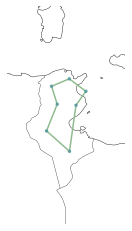

In [99]:
n.plot(bus_sizes=0.01, margin=1);

In [100]:
for bus in ["Centre East","Centre West","North East","North West","South East","South West"]:
    n.add(
    "StorageUnit",
    bus+" battery storage",
    bus=bus,
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    )

In [101]:
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    504 * costs.at["hydrogen storage underground", "capital_cost"]
)
for bus in ["Centre East","Centre West","North East","North West","South East","South West"]:
    n.add(
    "StorageUnit",
    bus+" hydrogen storage underground",
    bus=bus,
    carrier="hydrogen storage underground",
    max_hours=504,
    capital_cost=capital_costs,
    efficiency_store=costs.at["electrolysis", "efficiency"],
    efficiency_dispatch=costs.at["fuel cell", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

In [102]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Centre East battery storage,Centre East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
Centre West battery storage,Centre West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
North East battery storage,North East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
North West battery storage,North West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
South East battery storage,South East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
South West battery storage,South West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.0
Centre East hydrogen storage underground,Centre East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.0
Centre West hydrogen storage underground,Centre West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.0
North East hydrogen storage underground,North East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.0


In [103]:
#n.export_to_netcdf("temporary_model.nc")

In [104]:
#n_nc = pypsa.Network("temporary_model.nc")

In [105]:
n.lopf(solver_name='gurobi') 

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-31
Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-amqnh6zz.lp
Reading time = 2.71 seconds
obj: 418704 rows, 181569 columns, 847673 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418704 rows, 181569 columns and 847673 nonzeros
Model fingerprint: 0xa51989cd
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 194213 rows and 15606 columns
Presolve time: 1.80s
Presolved: 224491 rows, 165963 columns, 705747 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.24s

Barrier statistics:
 Dense cols : 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.56e+08


('ok', 'optimal')

In [106]:
#n.export_to_netcdf("BaseModel_links.nc")

In [107]:
n.generators_t.p


Generator,OCGT Centre East,OCGT Centre West,OCGT North East,hydro North East,hydro North West,OCGT South East,on shore Centre East,on shore Centre West,on shore North East,on shore North West,on shore South East,on shore South West,solar Centre East,solar Centre West,solar North East,solar North West,solar South East,solar South West,off_shore
snapshot,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,605.623990,304.000000,1259.614518,1.36872,8.398,385.247782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2020-01-01 03:00:00,600.974852,304.000000,1252.117151,1.36872,8.398,382.365932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2020-01-01 06:00:00,727.431106,304.000000,1456.045066,1.36872,8.398,460.379253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.085228,0.0,17.931825,0.0,0.372817,0.0
2020-01-01 09:00:00,825.415637,304.000000,1614.058453,1.36872,8.398,518.683160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,389.387320,0.0,163.159622,0.0,2.806347,0.0
2020-01-01 12:00:00,817.285366,304.000000,1600.947285,1.36872,8.398,513.307920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294.816932,0.0,124.533598,0.0,3.141895,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 09:00:00,822.449674,265.112467,1431.186318,1.36872,8.398,527.760323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.705021,0.0,249.425011,0.0,2.848414,0.0
2020-12-31 12:00:00,841.193268,209.697288,1639.502031,1.36872,8.398,528.000769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,561.539150,0.0,282.722182,0.0,3.268781,0.0
2020-12-31 15:00:00,853.563051,304.000000,1657.141254,1.36872,8.398,537.873398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175.309888,0.0,87.708566,0.0,1.063779,0.0


In [108]:
n.loads_t.p_set.head(3)

Load,Centre East demand,Centre West demand,North East demand,North West demand,South East demand,South West demand,Tunisian Exclusive Economic Zone demand
snapshot,,,,,,,
2020-01-01 00:00:00,605.623990,336.646538,976.651083,273.755500,234.594097,140.812607,0.0
2020-01-01 03:00:00,600.974852,334.062234,969.153716,271.653987,232.793210,139.731644,0.0
2020-01-01 06:00:00,727.431106,404.355124,1173.081631,328.815024,281.777219,169.133773,0.0


<AxesSubplot:xlabel='snapshot', ylabel='p.u.'>

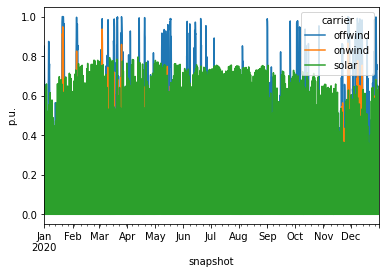

In [109]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot(ylabel='p.u.')

Text(0.5, 0, 'GW')

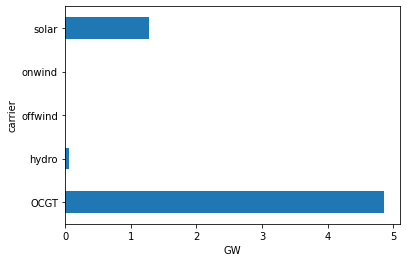

In [110]:
n.generators.groupby("carrier").p_nom_opt.sum().div(1e3).plot.barh()
plt.xlabel('GW')

In [111]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Centre East battery storage,Centre East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.000000
Centre West battery storage,Centre West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,305.786253
North East battery storage,North East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,50.087519
North West battery storage,North West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,225.012919
South East battery storage,South East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,0.000000
South West battery storage,South West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,6.0,0.96,0.96,0.0,0.0,33.686217
Centre East hydrogen storage underground,Centre East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.000000
Centre West hydrogen storage underground,Centre West,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.000000
North East hydrogen storage underground,North East,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,504.0,0.68,0.50,0.0,0.0,0.000000


In [112]:
line_loading = n.links_t.p0.iloc[0].abs() / n.links.p_nom / n.links.p_max_pu * 100 # %

In [113]:
line_loading

Link
North East_Tunisian Exclusive Economic Zone     NaN
Tunisian Exclusive Economic Zone_Centre East    NaN
Centre East_South East                          NaN
South East_South West                           inf
South West_Centre West                          inf
Centre West_North West                          inf
North West_North East                           inf
dtype: float64

In [114]:
norm = plt.Normalize(vmin=0, vmax=100)

C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


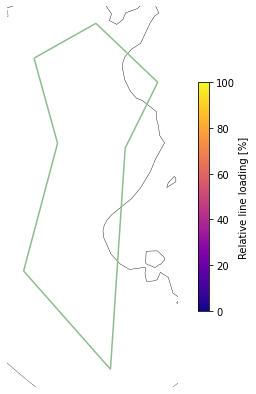

In [115]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=n.links.p_nom /100
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

In [116]:
p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

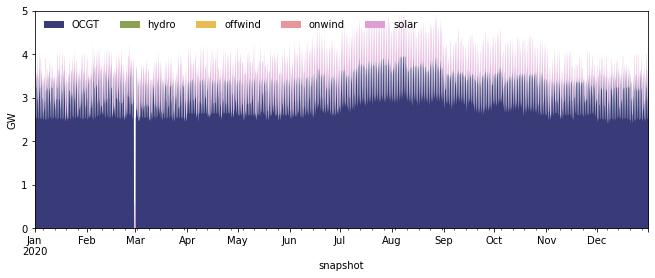

In [117]:
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    cmap='tab20b',
)

ax.legend(
    ncol=5,
    loc="upper left",
    frameon=False
)

ax.set_ylabel("GW")

ax.set_ylim(0,5);

Text(0.5, 0, 'Months')

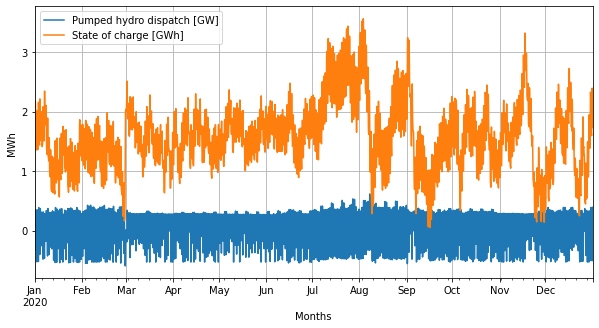

In [118]:
fig, ax = plt.subplots(figsize=(10,5))

p_storage = n.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

p_storage.plot(label="Pumped hydro dispatch [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

ax.grid()
ax.legend()
ax.set_ylabel("MWh")
ax.set_xlabel("Months")

### The locational marginal prices (LMPs):



C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


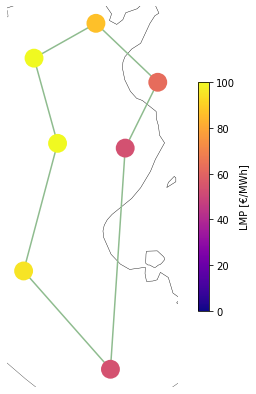

In [119]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

norm = plt.Normalize(vmin=0, vmax=100) # €/MWh

n.plot(
    ax=ax,
    bus_colors=n.buses_t.marginal_price.mean(),
    bus_cmap='plasma',
    bus_norm=norm,
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='LMP [€/MWh]',
    shrink=0.6
)

#### The total system cost in billion Euros per year:

In [120]:
n.objective / 1e9

0.6556404626058846

#### The optimised capacities in GW:

In [121]:
n.generators.p_nom_opt.div(1e3) # GW

Generator
OCGT Centre East        1.951000
OCGT Centre West        0.304000
OCGT North East         1.945000
hydro North East        0.004800
hydro North West        0.049400
OCGT South East         0.656000
on shore Centre East    0.000000
on shore Centre West    0.000000
on shore North East     0.000000
on shore North West     0.000000
on shore South East     0.000000
on shore South West     0.000000
solar Centre East       0.000000
solar Centre West       0.827800
solar North East        0.000000
solar North West        0.441203
solar South East        0.000000
solar South West        0.004722
off_shore               0.000000
Name: p_nom_opt, dtype: float64

#### The total energy generation by technology in GW:

In [122]:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6)
# TWh

Generator
OCGT Centre East        2.339315
OCGT Centre West        0.779752
OCGT North East         4.535777
hydro North East        0.004008
hydro North West        0.024589
OCGT South East         1.467779
on shore Centre East    0.000000
on shore Centre West    0.000000
on shore North East     0.000000
on shore North West     0.000000
on shore South East     0.000000
on shore South West     0.000000
solar Centre East       0.000000
solar Centre West       0.521461
solar North East        0.000000
solar North West        0.266042
solar South East        0.000000
solar South West        0.003183
off_shore               0.000000
Name: generators, dtype: float64

####  the costs distribution across the technologies

In [123]:
opex = n.snapshot_weightings.generators @ (n.generators_t.p * n.generators.marginal_cost).div(1e6) # M€/a

In [124]:
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6) # M€/a

In [125]:
capex + opex

Generator
OCGT Centre East        125.210422
OCGT Centre West         41.735733
OCGT North East         242.774684
hydro North East          0.000000
hydro North West          0.000000
OCGT South East          78.561954
on shore Centre East      0.000000
on shore Centre West      0.000000
on shore North East       0.000000
on shore North West       0.000000
on shore South East       0.000000
on shore South West       0.000000
solar Centre East         0.000000
solar Centre West        38.505289
solar North East          0.000000
solar North West         20.522536
solar South East          0.000000
solar South West          0.219664
off_shore                 0.000000
dtype: float64

####  The total emissions:

In [126]:
emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

In [127]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

4.45005963335483

#### Plotting Optimal Dispatch

In [128]:
def plot_dispatch(n, time="2020-07"):
    
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    
    fig, ax = plt.subplots(figsize=(6, 3))
    
    color = p_by_carrier.columns.map(n.carriers.color)
    
    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k',label='load')

    plt.legend(loc=(1.05,0))
    ax.set_ylabel("GW")
    ax.set_ylim(-2, 5)

C:\Users\bilwi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


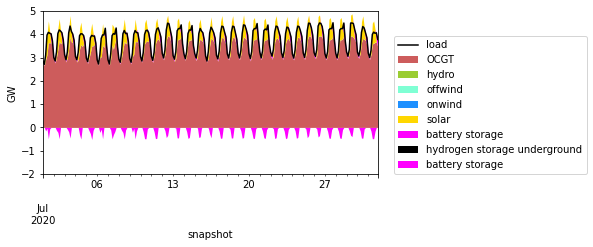

In [129]:
plot_dispatch(n)

In [130]:
n.storage_units.p_nom_opt # MW

StorageUnit
Centre East battery storage                   0.000000
Centre West battery storage                 305.786253
North East battery storage                   50.087519
North West battery storage                  225.012919
South East battery storage                    0.000000
South West battery storage                   33.686217
Centre East hydrogen storage underground      0.000000
Centre West hydrogen storage underground      0.000000
North East hydrogen storage underground       0.000000
North West hydrogen storage underground       0.000000
South East hydrogen storage underground       0.000000
South West hydrogen storage underground       0.000000
Name: p_nom_opt, dtype: float64

In [131]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours # GWh

StorageUnit
Centre East battery storage                 0.000000
Centre West battery storage                 1.834718
North East battery storage                  0.300525
North West battery storage                  1.350078
South East battery storage                  0.000000
South West battery storage                  0.202117
Centre East hydrogen storage underground    0.000000
Centre West hydrogen storage underground    0.000000
North East hydrogen storage underground     0.000000
North West hydrogen storage underground     0.000000
South East hydrogen storage underground     0.000000
South West hydrogen storage underground     0.000000
dtype: float64

In [132]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [133]:
system_cost(n)

carrier
battery storage                 59.266315
hydrogen storage underground     0.000000
OCGT                             0.166763
hydro                            0.000000
offwind                          0.000000
onwind                           0.000000
solar                           59.239585
AC                              48.843868
dtype: float64

<AxesSubplot:ylabel='System cost [million €/a]'>

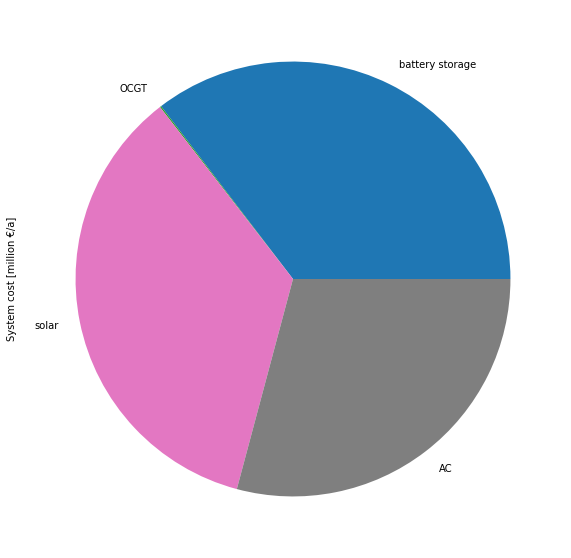

In [134]:
system_cost(n).plot.pie(figsize=(10,10),ylabel="System cost [million €/a]")

## Adding emission limits



In [135]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

In [136]:
n.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-68eru6x4.lp
Reading time = 2.76 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xf24c4432
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.21s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.15s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09


('ok', 'optimal')

In [137]:
#n.export_to_netcdf("CO2limiter _model_links.nc")

In [138]:
n.generators_t.p

Generator,OCGT Centre East,OCGT Centre West,OCGT North East,hydro North East,hydro North West,OCGT South East,on shore Centre East,on shore Centre West,on shore North East,on shore North West,on shore South East,on shore South West,solar Centre East,solar Centre West,solar North East,solar North West,solar South East,solar South West,off_shore
snapshot,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,618.738286,59.703280,124.464758,0.0,126.590484,15.742059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,587.167589,48.370138,164.443786,0.0,98.796904,11.925791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-01 06:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,523.175239,35.999783,139.582011,0.0,84.286440,8.901988,223.311209,150.690391,303.638172,94.138635,110.304948,78.809858,0.0
2020-01-01 09:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,248.040241,21.971434,160.604112,0.0,59.782478,2.899072,1597.481163,1171.541577,2355.641050,856.556657,759.361827,593.234678,0.0
2020-01-01 12:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,317.443684,31.793383,384.794920,0.0,45.274542,0.000000,1463.871761,887.009607,2519.031045,653.777455,862.793925,598.441844,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 09:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,14.552697,0.000000,202.953048,0.0,1.581064,0.000000,2039.302852,1412.626649,3571.959439,1261.876795,864.677077,599.642589,0.0
2020-12-31 12:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2021.906092,1423.045599,3833.188021,1270.349316,918.085344,604.000630,0.0
2020-12-31 15:00:00,0.0,0.0,0.0,1.36872,8.398,0.0,77.369650,24.513711,30.354056,0.0,1.220080,1.067843,667.706803,527.451236,1075.938132,460.453113,268.741694,224.872686,0.0


<AxesSubplot:xlabel='snapshot', ylabel='p.u.'>

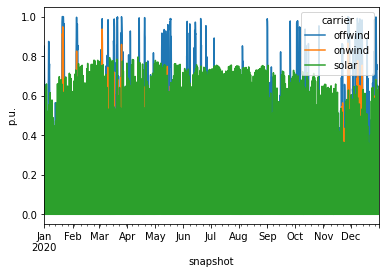

In [139]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot(ylabel='p.u.')

Text(0.5, 0, 'GW')

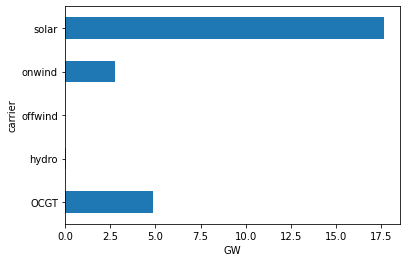

In [140]:
n.generators.groupby("carrier").p_nom_opt.sum().div(1e3).plot.barh()
plt.xlabel('GW')

In [141]:
line_loading = n.links_t.p0.iloc[0].abs() / n.links.p_nom / n.links.p_max_pu * 100 # %

In [142]:
norm = plt.Normalize(vmin=0, vmax=100)

C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


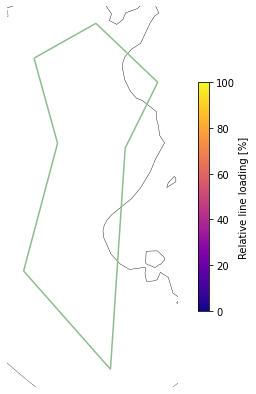

In [143]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=n.links.p_nom /100
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

In [144]:
p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

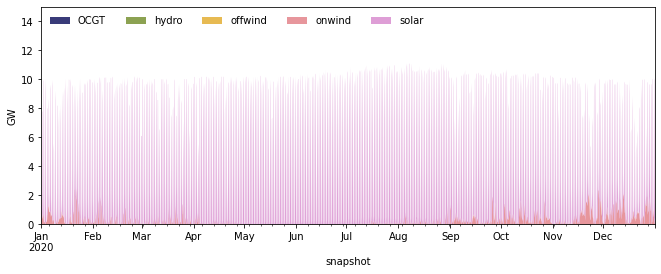

In [145]:
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    cmap='tab20b',
)

ax.legend(
    ncol=5,
    loc="upper left",
    frameon=False
)

ax.set_ylabel("GW")

ax.set_ylim(0,15);

Text(0.5, 0, 'Months')

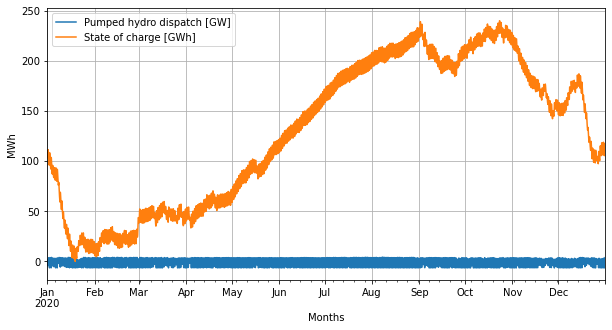

In [146]:
fig, ax = plt.subplots(figsize=(10,5))

p_storage = n.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

p_storage.plot(label="Pumped hydro dispatch [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

ax.grid()
ax.legend()
ax.set_ylabel("MWh")
ax.set_xlabel("Months")

C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\bilwi\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


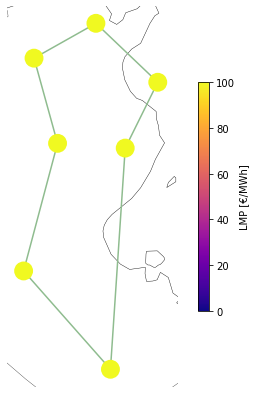

In [147]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

norm = plt.Normalize(vmin=0, vmax=100) # €/MWh

n.plot(
    ax=ax,
    bus_colors=n.buses_t.marginal_price.mean(),
    bus_cmap='plasma',
    bus_norm=norm,
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='LMP [€/MWh]',
    shrink=0.6
)

In [148]:
n.objective / 1e9

1.828946577052861

In [149]:
n.generators.p_nom_opt.div(1e3) # GW

Generator
OCGT Centre East        1.951000
OCGT Centre West        0.304000
OCGT North East         1.945000
hydro North East        0.004800
hydro North West        0.049400
OCGT South East         0.656000
on shore Centre East    1.122633
on shore Centre West    0.266430
on shore North East     1.172062
on shore North West     0.000000
on shore South East     0.157980
on shore South West     0.051015
solar Centre East       3.436456
solar Centre West       2.490586
solar North East        6.951582
solar North West        2.316232
solar South East        1.456421
solar South West        0.998263
off_shore               0.000000
Name: p_nom_opt, dtype: float64

In [150]:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6)
# TWh

Generator
OCGT Centre East        0.000000
OCGT Centre West        0.000000
OCGT North East         0.000000
hydro North East        0.004008
hydro North West        0.024589
OCGT South East         0.000000
on shore Centre East    0.337529
on shore Centre West    0.036017
on shore North East     0.272848
on shore North West     0.000000
on shore South East     0.051346
on shore South West     0.006282
solar Centre East       2.007936
solar Centre West       1.350445
solar North East        3.761173
solar North West        1.208666
solar South East        0.922279
solar South West        0.576300
off_shore               0.000000
Name: generators, dtype: float64

In [151]:
opex = n.snapshot_weightings.generators @ (n.generators_t.p * n.generators.marginal_cost).div(1e6) # M€/a

In [152]:
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6) # M€/a

In [153]:
capex + opex

Generator
OCGT Centre East          0.000000
OCGT Centre West          0.000000
OCGT North East           0.000000
hydro North East          0.000000
hydro North West          0.000000
OCGT South East           0.000000
on shore Centre East    108.324893
on shore Centre West     25.648807
on shore North East     112.986944
on shore North West       0.000000
on shore South East      15.248966
on shore South West       4.910288
solar Centre East       159.845833
solar Centre West       115.847882
solar North East        323.348013
solar North West        107.737492
solar South East         67.745745
solar South West         46.433863
off_shore                 0.000000
dtype: float64

In [154]:
emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

In [155]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

0.0

In [156]:
def plot_dispatch(n, time="2020-07"):
    
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    color = p_by_carrier.columns.map(n.carriers.color)
    
    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k',label="load")

    plt.legend(loc=(1.05,0))
    ax.set_ylabel("GW")
    ax.set_ylim(-8, 12)

C:\Users\bilwi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


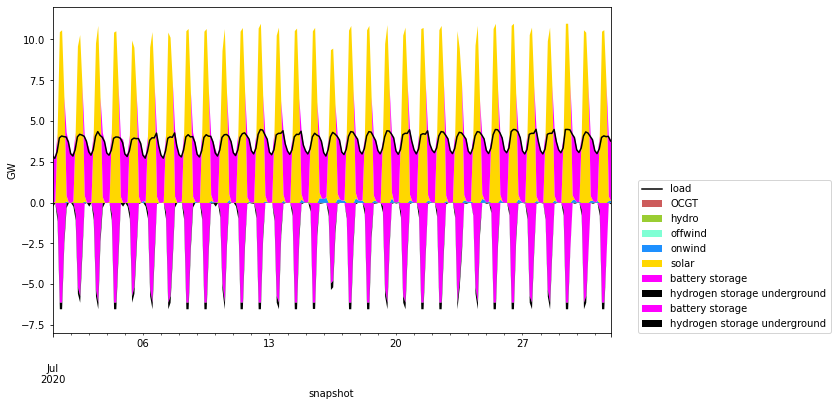

In [157]:
plot_dispatch(n)

In [158]:
n.storage_units.p_nom_opt # MW

StorageUnit
Centre East battery storage                 1178.612176
Centre West battery storage                  946.670198
North East battery storage                  2246.385835
North West battery storage                   782.867908
South East battery storage                   556.197269
South West battery storage                   398.738144
Centre East hydrogen storage underground      85.343808
Centre West hydrogen storage underground      29.948301
North East hydrogen storage underground      218.113943
North West hydrogen storage underground       46.617424
South East hydrogen storage underground       23.856548
South West hydrogen storage underground        0.000000
Name: p_nom_opt, dtype: float64

In [159]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours # GWh

StorageUnit
Centre East battery storage                   7.071673
Centre West battery storage                   5.680021
North East battery storage                   13.478315
North West battery storage                    4.697207
South East battery storage                    3.337184
South West battery storage                    2.392429
Centre East hydrogen storage underground     43.013279
Centre West hydrogen storage underground     15.093944
North East hydrogen storage underground     109.929427
North West hydrogen storage underground      23.495182
South East hydrogen storage underground      12.023700
South West hydrogen storage underground       0.000000
dtype: float64

In [160]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [161]:
system_cost(n)

carrier
battery storage                 589.166649
hydrogen storage underground    132.279006
OCGT                              0.000000
hydro                             0.000000
offwind                           0.000000
onwind                          266.169791
solar                           820.860594
AC                               19.422197
dtype: float64

<AxesSubplot:ylabel='System cost [million €/a]'>

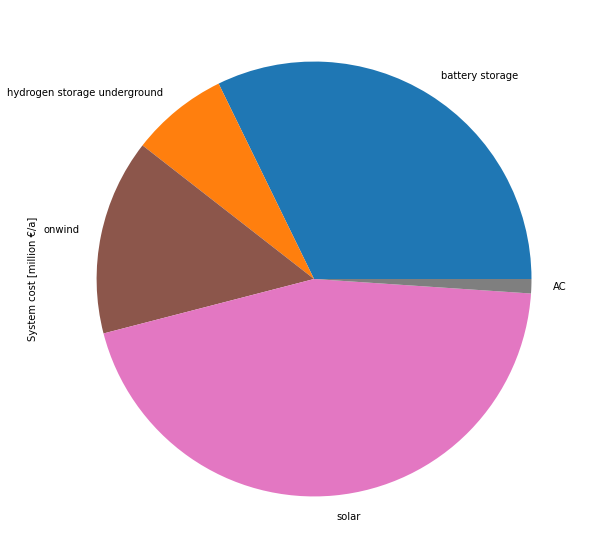

In [162]:
system_cost(n).plot.pie(figsize=(10,10),ylabel="System cost [million €/a]")

In [163]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)

In [164]:
system_cost(n).sum()*1e6 / demand.sum()

184.2710616798193

## Sensitivity Analysis

### Variations of technology costs :Successively reduce the capital cost of a technology of your choice (e.g. solar, wind, electrolysis, battery) down to 0% in 20% steps and describe how the optimised system changes.

In [165]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
OCGT Centre East,Centre East,Slack,,1951.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1951.000000
OCGT Centre West,Centre West,Slack,,304.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,304.000000
OCGT North East,North East,Slack,,1945.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1945.000000
hydro North East,North East,PQ,,4.8,False,0.0,inf,0.0,0.28515,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4.800000
hydro North West,North West,Slack,,49.4,False,0.0,inf,0.0,0.17000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,49.400000
OCGT South East,South East,Slack,,656.0,False,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,656.000000
on shore Centre East,Centre East,PQ,,0.0,True,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1122.633419
on shore Centre West,Centre West,PQ,,0.0,True,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,266.430209
on shore North East,North East,PQ,,0.0,True,0.0,inf,0.0,1.00000,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1172.061796


In [166]:
n.carriers.color

Carrier
onwind                           dodgerblue
offwind                          aquamarine
solar                                  gold
OCGT                              indianred
battery storage                     magenta
hydro                           yellowgreen
hydrogen storage underground          black
Name: color, dtype: object

In [167]:
sensitivity1 = {}
for solar_cost in [0, 9301, 18603,27904, 37206,46508 ]:
    n.generators.loc["solar North East", "capital_cost"] = solar_cost 
    n.generators.loc["solar North West", "capital_cost"] = solar_cost 
    n.generators.loc["solar Centre East", "capital_cost"] = solar_cost
    n.generators.loc["solar Centre West", "capital_cost"] = solar_cost 
    n.generators.loc["solar South East", "capital_cost"] = solar_cost
    n.generators.loc["solar South West", "capital_cost"] = solar_cost
    n.lopf(solver_name='gurobi')
    sensitivity1[solar_cost] = system_cost(n)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-hg2_t5vt.lp
Reading time = 2.63 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x18ca8de0
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 218180 rows and 41003 columns
Presolve time: 2.26s
Presolved: 200525 rows, 140566 columns, 661638 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.13s

Barrier statistics:
 Dense cols : 26
 Free vars  : 8784
 AA' NZ     : 7.480e+05
 Factor NZ  : 3.530e+06 (roughly 170 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-ij7wbigk.lp
Reading time = 2.67 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x1e008781
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.02s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.21s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7394888e-09     44s


Solved with barrier
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   69610    9.4813680e+08   0.000000e+00   0.000000e+00     44s

Solved in 69610 iterations and 43.97 seconds (15.98 work units)
Optimal objective  9.481367979e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 9.48e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-shdkgist.lp
Reading time = 2.68 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xdddf6d6d
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.16s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.15s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-qu1zw4nt.lp
Reading time = 2.68 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x70b6c5b9
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 2.97s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.19s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-_8113ukj.lp
Reading time = 2.71 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xa8b68634
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.01s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.17s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.66e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-tfjztxsi.lp
Reading time = 2.81 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xaf7e1183
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.11s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.15s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09


<AxesSubplot:xlabel='Solar Capital Cost [€/MW/a]', ylabel='System cost [bn€/a]'>

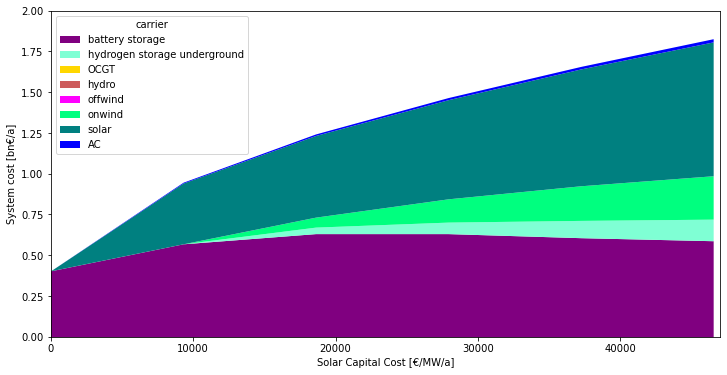

In [178]:
df1 = pd.DataFrame(sensitivity1).T.div(1e3) # billion Euro/a
df1.plot.area(
    stacked=True,
    linewidth=0,
    #color=df1.columns.map(n.carriers.color),
    color=["purple", "aquamarine", "gold", "indianred", "magenta", "springgreen","teal","blue"],
    figsize=(12,6),
    xlim=(0,47000),
    xlabel="Solar Capital Cost [€/MW/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0,2),
)

###  Variations of renewable potentials:Successively reduce the installable potential of a technology of your choice (e.g. solar, on-/offshore wind) down to 0% in 20% steps and describe how the optimised system changes.

In [169]:
n.generators.loc["solar Centre West", "p_nom_max"] 

inf

In [170]:
sensitivity2 = {}
for solar_potential in [0, 20,40,60,80, 100]:
    n.generators.loc["solar North West", "p_nom_max"] = solar_potential * 1e3
    n.generators.loc["solar North East", "p_nom_max"] = solar_potential  * 1e3
    n.generators.loc["solar South West", "p_nom_max"] = solar_potential * 1e3
    n.generators.loc["solar South East", "p_nom_max"] = solar_potential  * 1e3
    n.generators.loc["solar Centre West", "p_nom_max"] = solar_potential * 1e3
    n.generators.loc["solar Centre East", "p_nom_max"] = solar_potential  * 1e3
    n.lopf(solver_name='gurobi')
    sensitivity2[solar_potential] = system_cost(n)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-ax8zmdgh.lp
Reading time = 2.71 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x8ba2ee5c
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 207912 rows and 41022 columns
Presolve time: 3.01s
Presolved: 210793 rows, 140547 columns, 682164 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.17s

Barrier statistics:
 Dense cols : 26
 Free vars  : 8783
 AA' NZ     : 7.788e+05
 Factor NZ  : 3.403e+06 (roughly 170 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-wcuymu0q.lp
Reading time = 2.68 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x20b2155e
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [2e+04, 2e+04]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.28s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.14s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-i9yaw87l.lp
Reading time = 2.69 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0x33910ce3
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [4e+04, 4e+04]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.22s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.14s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 5.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-9_p_6x1q.lp
Reading time = 3.88 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xa68707aa
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [6e+04, 6e+04]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.08s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.16s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.37s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-zx_mwahy.lp
Reading time = 2.70 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xeb681d6b
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [8e+04, 8e+04]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.37s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.18s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-abgutyl7.lp
Reading time = 2.68 seconds
obj: 418705 rows, 181569 columns, 859385 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 418705 rows, 181569 columns and 859385 nonzeros
Model fingerprint: 0xc0200777
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 3e+05]
  Bounds range     [1e+05, 1e+05]
  RHS range        [1e+00, 2e+03]
Presolve removed 197624 rows and 30728 columns
Presolve time: 3.06s
Presolved: 221081 rows, 150841 columns, 723283 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.19s

Barrier statistics:
 Dense cols : 32
 Free vars  : 8784
 AA' NZ     : 8.096e+05
 Factor NZ  : 3.585e+06 (roughly 180 MB of me

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09


<AxesSubplot:xlabel='solar installed [GW]', ylabel='System cost [bn€/a]'>

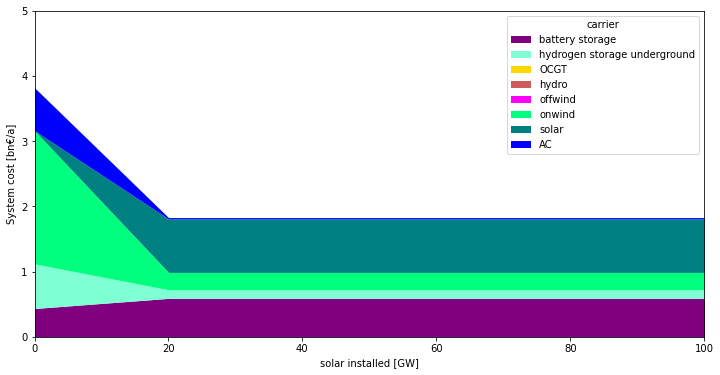

In [177]:
df2 = pd.DataFrame(sensitivity2).T.div(1e3) # billion Euro/a
df2.plot.area(
    stacked=True,
    linewidth=0,
    color=["purple", "aquamarine", "gold", "indianred", "magenta", "springgreen","teal","blue"],
    figsize=(12,6),
    xlim=(0,100),
    xlabel="solar installed [GW]",
    ylabel="System cost [bn€/a]",
    ylim=(0,5),
)